In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn

from transformers import AutoTokenizer, DistilBertModel
from transformers import AdamW


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
  print("You are running on CPU")

NVIDIA GeForce GTX 1050 Ti


In [3]:
df = pd.read_csv("../Datasets/Cuvinte-Eliminate/train-punct-stop-1000.csv")
df=df.dropna()
df=df.sample(n=100000)

In [4]:
df.head()

,sentiment,text
479589,2,really cds set player get ready journey like n...
626331,2,although harold battles book small simply hard...
346982,2,whats base black red root bark bark sesame see...
1605488,0,bought product hooking found need telephone ja...
1051640,2,absolutely love mobile received mail today son...


In [5]:
df['sentiment'] = df['sentiment'].replace(2,1)

In [6]:
df.head()

,sentiment,text
479589,1,really cds set player get ready journey like n...
626331,1,although harold battles book small simply hard...
346982,1,whats base black red root bark bark sesame see...
1605488,0,bought product hooking found need telephone ja...
1051640,1,absolutely love mobile received mail today son...


In [7]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize_function(example):
    tok = tokenizer(example, padding="max_length", truncation=True)
    return tok['input_ids'], tok['attention_mask']
    
df['input_ids'], df['attention_mask'] = zip(*df['text'].map(tokenize_function))

df_train, df_test = train_test_split(df, test_size=0.2)

In [8]:
df.head()

,sentiment,text,input_ids,attention_mask
479589,1,really cds set player get ready journey like n...,"[101, 2428, 14340, 2275, 2447, 2131, 3201, 499...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
626331,1,although harold battles book small simply hard...,"[101, 2348, 7157, 7465, 2338, 2235, 3432, 2524...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
346982,1,whats base black red root bark bark sesame see...,"[101, 2054, 2015, 2918, 2304, 2417, 7117, 1128...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1605488,0,bought product hooking found need telephone ja...,"[101, 4149, 4031, 8103, 2075, 2179, 2342, 7026...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1051640,1,absolutely love mobile received mail today son...,"[101, 7078, 2293, 4684, 2363, 5653, 2651, 2365...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        return {
            'input_ids' : torch.tensor(item['input_ids']).to(device),
            'attention_mask' : torch.tensor(item['attention_mask']).to(device),
            'labels' : torch.tensor(item['sentiment']).to(device)
        }

train_set = Dataset(df_train)
test_set = Dataset(df_test)

In [10]:
class Classifier(nn.Module):
    def __init__(self, out_feat=2):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.cls = nn.Linear(768, out_feat)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
        )
 
        pooled_output = outputs.last_hidden_state[:,0,:] #[batch_dim, token_dim, ...] [CLS]
        logits = self.cls(pooled_output)
        return F.softmax(logits, dim=1)

    def freeze_until_layer(self, n):
      for name, param in self.named_parameters():
        if str(n) in name:
          break

        param.requires_grad = False
        
    def print_layers(self):
      total_nr_w = 0
      trainable_nr_w = 0
      for name, param in self.named_parameters():
        nr_w = np.prod(param.size())
        total_nr_w += nr_w
        if param.requires_grad:
          trainable_nr_w += nr_w
        print('{}\t{}\t\t\t{}'.format(param.requires_grad, nr_w ,name))
      print('The network has {} parameters, out of which {} ({:.1f}%) are trainable.'.format(total_nr_w, trainable_nr_w, trainable_nr_w / total_nr_w * 100))

model = Classifier(2).to(device) # generez o instanță a modelului
print(model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features

In [11]:
model.freeze_until_layer(5)
model.print_layers()

False	23440896			bert.embeddings.word_embeddings.weight
False	393216			bert.embeddings.position_embeddings.weight
False	768			bert.embeddings.LayerNorm.weight
False	768			bert.embeddings.LayerNorm.bias
False	589824			bert.transformer.layer.0.attention.q_lin.weight
False	768			bert.transformer.layer.0.attention.q_lin.bias
False	589824			bert.transformer.layer.0.attention.k_lin.weight
False	768			bert.transformer.layer.0.attention.k_lin.bias
False	589824			bert.transformer.layer.0.attention.v_lin.weight
False	768			bert.transformer.layer.0.attention.v_lin.bias
False	589824			bert.transformer.layer.0.attention.out_lin.weight
False	768			bert.transformer.layer.0.attention.out_lin.bias
False	768			bert.transformer.layer.0.sa_layer_norm.weight
False	768			bert.transformer.layer.0.sa_layer_norm.bias
False	2359296			bert.transformer.layer.0.ffn.lin1.weight
False	3072			bert.transformer.layer.0.ffn.lin1.bias
False	2359296			bert.transformer.layer.0.ffn.lin2.weight
False	768			bert.transformer.l

In [12]:
def evaluate(model):
  # Pregatim o modalitate de stocare a datelor pentru evaluare
  eval_outputs = []
  true_labels = []
  # Trecem modelul in modul train
  model.eval()

  ########### Evaluation Loop #############
  with torch.no_grad():
      for batch in tqdm(test_loader, total=len(test_loader)):
          outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

          outputs = outputs.cpu() ## copy-ing the outputs from CUDA to CPU
          outputs = np.argmax(outputs, axis=1)

          eval_outputs += outputs.tolist()
          true_labels += batch['labels'].tolist()

  #acc = metrics.accuracy_score(true_labels, eval_outputs)
  f1 = metrics.f1_score(true_labels, eval_outputs)
  print("F1: {}".format(f1) , end =" ")

In [13]:
LEARNING_RATE = 5e-5 # Rata de invatare
NR_EPOCHS = 8 # Numarul de epoci
BATCH_SIZE = 32 # Numarul de samples dintr-un batch

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Pregatim o modalitate de loggare a informatiilor din timpul antrenarii
log_info = []

# Pregatim DataLoader-ul pentru antrenare
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# Pregatim DataLoader-ul pentru validare
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

# Trecem modelul in modul train
model.train() 


########### Training Loop #############


min_epoch_loss = np.Inf
last_epoch_loss = np.Inf
# pentru fiecare epoca (1 epoca = o iteratie peste intregul set de date)
for epoch in range(NR_EPOCHS):
    print('Running epoch {}'.format(epoch), end =" ")

    epoch_losses = []
    # pentru fiecare batch de BATCH_SIZE exemple din setul de date    
    for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):

        # anulam gradientii deja acumulati la nivelul retelei neuronale
        optimizer.zero_grad()

        # FORWARD PASS: trecem inputurile prin retea
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Calculam LOSSul dintre etichetele prezise si cele reale
        loss = criterion(outputs, batch['labels'])

        # BACKPRPAGATION: calculam gradientii propagand LOSSul in retea
        loss.backward()

        # Utilizam optimizorul pentru a modifica parametrii retelei in functie de gradientii acumulati
        optimizer.step()

        # Salvam informatii despre antrenare (in cazul nostru, salvam valoarea LOSS)
        epoch_losses.append(loss.item()) 
    
    this_epoch_loss = np.mean(epoch_losses)
    log_info.append((epoch, this_epoch_loss))
    
    if this_epoch_loss <= min_epoch_loss:
      min_epoch_loss = this_epoch_loss
      print("Saving model with train loss: {}".format(this_epoch_loss), end =" ")
      torch.save(model, "classfication_model.pt")

    evaluate(model)
    
    if last_epoch_loss - this_epoch_loss < 0.01:
      print("Early Stopping!")
      break

    last_epoch_loss = this_epoch_loss

  0%|                                                  | 0/2500 [00:00<?, ?it/s]

Running epoch 0 

100%|█████████████████████████████████████| 2500/2500 [1:12:41<00:00,  1.74s/it]


Saving model with train loss: 0.47198699218034745 

  0%|                                                  | 0/2500 [00:00<?, ?it/s]

F1: 0.859075535512965 Running epoch 1 

100%|█████████████████████████████████████| 2500/2500 [1:10:32<00:00,  1.69s/it]


Saving model with train loss: 0.438261607503891 

  0%|                                                  | 0/2500 [00:00<?, ?it/s]

F1: 0.8652489367025269 Running epoch 2 

100%|█████████████████████████████████████| 2500/2500 [1:10:33<00:00,  1.69s/it]


Saving model with train loss: 0.42452582869529726 

  0%|                                                  | 0/2500 [00:00<?, ?it/s]

F1: 0.864169927333706 Running epoch 3 

100%|█████████████████████████████████████| 2500/2500 [1:10:43<00:00,  1.70s/it]


Saving model with train loss: 0.4136776436805725 

  0%|                                                  | 0/2500 [00:00<?, ?it/s]

F1: 0.8672026050676707 Running epoch 4 

100%|█████████████████████████████████████| 2500/2500 [1:10:43<00:00,  1.70s/it]


Saving model with train loss: 0.401535007750988 

  0%|                                                  | 0/2500 [00:00<?, ?it/s]

F1: 0.8736722493947926 Running epoch 5 

100%|█████████████████████████████████████| 2500/2500 [1:10:47<00:00,  1.70s/it]


Saving model with train loss: 0.3913104826927185 

  0%|                                                  | 0/2500 [00:00<?, ?it/s]

F1: 0.8619549493697044 Running epoch 6 

100%|█████████████████████████████████████| 2500/2500 [1:11:11<00:00,  1.71s/it]


Saving model with train loss: 0.3827972535967827 

100%|█████████████████████████████████████████| 625/625 [14:21<00:00,  1.38s/it]

F1: 0.86865598027127 Early Stopping!


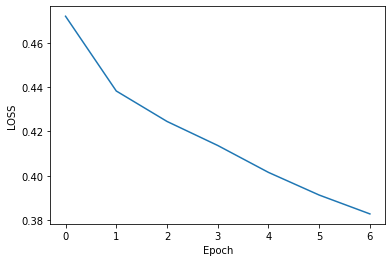

In [16]:
X = [x for x, loss in log_info]
Y = [loss for x, loss in log_info]
plt.plot(X,Y)
plt.xlabel("Epoch")
plt.ylabel("LOSS")
plt.show()

In [15]:
evaluate(model)

100%|█████████████████████████████████████████| 625/625 [14:20<00:00,  1.38s/it]

F1: 0.86865598027127 